# Early development work for:

## <ins>3</ins>D <ins>P</ins>rofiling of <ins>I</ins>mage-based or<ins>G</ins>anoid<ins>S</ins> (3PIGS)


## Imports

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
import scipy.signal
import skimage
import skimage.io as io
import skimage.morphology
import skimage.segmentation
from centrosome.cpmorphology import fixup_scipy_ndimage_result as fix
from scipy.linalg import lstsq

sys.path.append("../featurization")
import numpy
from area_size_shape import calulate_surface_area, measure_3D_area_size_shape
from colocalization import calculate_3D_colocalization
from granularity import measure_3D_granularity
from intensity import measure_3D_intensity
from neighbors import measure_3D_number_of_neighbors
from texture import measure_3D_texture

## Load images

In [2]:
input_dir = pathlib.Path("../../data/NF0014/cellprofiler/C4-2/")
clip_limit = 0.03
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]
# find the cytoplasmic channels in the image set
for f in files:
    if "405" in f:
        nuclei = io.imread(f)
    elif "488" in f:
        cyto1 = io.imread(f)
    elif "555" in f:
        cyto2 = io.imread(f)
    elif "640" in f:
        cyto3 = io.imread(f)
    elif "TRANS" in f:
        brightfield = io.imread(f)
    elif "nuclei" in f:
        nuclei_mask = io.imread(f)
    elif "cell_" in f:
        cell_mask = io.imread(f)
    elif "cytoplasm" in f:
        cytoplasm_mask = io.imread(f)
    elif "organoid" in f:
        organoid_mask = io.imread(f)

    else:
        print(f"Unknown channel: {f}")

# pick which channels to use for cellpose
cyto = skimage.exposure.equalize_adapthist(cyto2, clip_limit=clip_limit)


original_nuclei_image = nuclei.copy()
original_cyto_image = cyto.copy()

original_nuclei_z_count = nuclei.shape[0]
original_cyto_z_count = cyto.shape[0]

In [3]:
# get an image with only one mask


def get_image_with_mask(mask_array, mask_number):
    # get the mask for the organoid
    mask = np.zeros_like(mask_array)
    mask[mask_array == mask_number] = mask_number
    return mask


def get_object_mesh(mask):
    mesh_z, mesh_y, mesh_x = numpy.mgrid[
        0 : mask.shape[0],
        0 : mask.shape[1],
        0 : mask.shape[2],
    ]
    return mesh_z, mesh_y, mesh_x


# function that gets the outline of the mask


def get_outline(mask):
    outline = numpy.zeros_like(mask)
    for z in range(mask.shape[0]):
        outline[z] = skimage.segmentation.find_boundaries(mask[z])
    return outline


label_object = get_image_with_mask(nuclei_mask, 8)
label_object_1 = get_image_with_mask(nuclei_mask, 4)
print(label_object.shape, label_object_1.shape)
print(np.unique(label_object), np.unique(label_object_1))

(33, 1537, 1540) (33, 1537, 1540)
[0 8] [0 4]


In [4]:
SPACING = (1.0, 0.1, 0.1)
spacing = SPACING
# TODO: add func to get the spacing from the image metadata

(33, 1537, 1540) (33, 1537, 1540) (33, 1537, 1540)


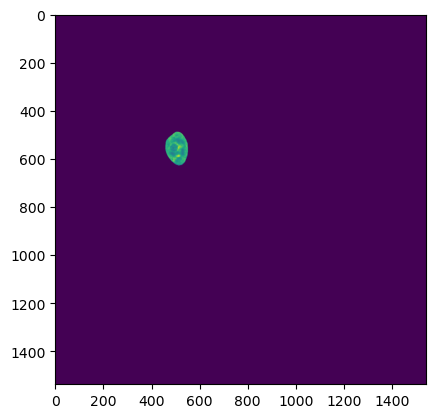

In [5]:
image_object = nuclei.copy()
image_object_1 = nuclei.copy()
image_shape = image_object.shape


def generate_mesh(image_object):
    mesh_z, mesh_y, mesh_x = numpy.mgrid[
        0 : image_object.shape[0],
        0 : image_object.shape[1],
        0 : image_object.shape[2],
    ]
    return mesh_z, mesh_y, mesh_x


mesh_z, mesh_y, mesh_x = generate_mesh(image_object)
print(mesh_z.shape, mesh_y.shape, mesh_x.shape)
# set all image pixels to 0 if not in mask
image_object[label_object == 0] = 0
image_object_1[label_object_1 == 0] = 0

non_zero_pixels_object = image_object[image_object > 0]
mask_outlines = get_outline(label_object)
# mesh_x = mesh_x[label_object > 0]
# mesh_y = mesh_y[label_object > 0]
# mesh_z = mesh_z[label_object > 0]
plt.imshow(image_object[4])
plt.show()

## Notes

But also convert masks to point clouds. 


Modules to make: (from https://cellprofiler-manual.s3.amazonaws.com/CellProfiler-4.2.8/modules/measurement.html)
- Colocalization
    - Correlation
    - Slope
    - Overlap coefficient
    - Manders' coefficient
    - Manders coefficient (Costes Automated Threshold): 
    - Rank Weighted Colocalization coefficient
- Ganularity
- Intensity
    - IntegratedIntensity
    - MeanIntensity
    - StdIntensity
    - MaxIntensity
    - MinIntensity
    - IntegratedIntensityEdge
    - MeanIntensityEdge
    - StdIntensityEdge
    - MaxIntensityEdge
    - MinIntensityEdge
    - MassDisplacement
    - LowerQuartileIntensity
    - MedianIntensity
    - MADIntensity
    - UpperQuartileIntensity
    - LocationCenterMassIntensity
    - LocationMaxIntensity

- Neighbors
    - NumberOfNeighbors
    - PercentTouching
    - FirstClosestObjectNumber
    - FirstClosestDistance
    - SecondClosestObjectNumber
    - SecondClosestDistance
    - AngleBetweenNeighbors
- SizeShape
    - Volume
    - SuraceArea
    - ConvexArea
    - Solidity
    - Extent
    - EulerNumber
    - Center coordinates
    - Bounding box
    - Bounding box volume
    - MajorAxisLength
    - MinorAxisLength
    - EquivalentDiameter
- Texture
    - AngularSecondMoment
    - Contrast
    - Correlation
    - Variance
    - InverseDifferenceMoment
    - SumAverage
    - SumVariance
    - SumEntropy
    - Entropy
    - DifferenceVariance
    - DifferenceEntropy
    - InfoMeas1
    - InfoMeas2
    

## Area Size Shape

In [34]:
measure_3D_area_size_shape(label_object, spacing)

{'VOLUME': array([80885.]),
 'SURFACE_AREA': 566.3780228126928,
 'MAJOR_AXIS_LENGTH': array([148.60303519]),
 'MINOR_AXIS_LENGTH': array([10.97863858]),
 'CENTER_X': array([507.44136737]),
 'CENTER_Y': array([560.0680225]),
 'CENTER_Z': array([4.66945664]),
 'BBOX_VOLUME': array([119286.]),
 'MIN_X': array([458]),
 'MAX_X': array([552]),
 'MIN_Y': array([489]),
 'MAX_Y': array([630]),
 'MIN_Z': array([1]),
 'MAX_Z': array([10]),
 'EXTENT': array([0.67807622]),
 'EULER_NUMBER': array([1]),
 'EQUIVALENT_DIAMETER': array([53.65659664])}

## Colocalization

### get the objects need for the colocalization analysis

In [6]:
def expand_box(min_coor, max_coord, current_min, current_max, expand_by):
    if max_coord - min_coor - (current_max - current_min) < expand_by:
        return ValueError("Cannot expand box by the requested amount")
    while expand_by > 0:
        if current_min > min_coor:
            current_min -= 1
            expand_by -= 1
        elif current_max < max_coord:
            current_max += 1
            expand_by -= 1

    return current_min, current_max


def new_crop_border(bbox1, bbox2, image):
    i1z1, i1y1, i1x1, i1z2, i1y2, i1x2 = bbox1
    i2z1, i2y1, i2x1, i2z2, i2y2, i2x2 = bbox2
    z_range1 = i1z2 - i1z1
    y_range1 = i1y2 - i1y1
    x_range1 = i1x2 - i1x1
    z_range2 = i2z2 - i2z1
    y_range2 = i2y2 - i2y1
    x_range2 = i2x2 - i2x1
    z_diff = np.abs(z_range1 - z_range2)
    y_diff = np.abs(y_range1 - y_range2)
    x_diff = np.abs(x_range1 - x_range2)
    min_z_coord = 0
    max_z_coord = image.shape[0]
    min_y_coord = 0
    max_y_coord = image.shape[1]
    min_x_coord = 0
    max_x_coord = image.shape[2]
    if z_range1 < z_range2:
        i1z1, i1z2 = expand_box(
            min_coor=min_z_coord,
            max_coord=max_z_coord,
            current_min=i1z1,
            current_max=i1z2,
            expand_by=z_diff,
        )
    elif z_range1 > z_range2:
        i2z1, i2z2 = expand_box(
            min_coor=min_z_coord,
            max_coord=max_z_coord,
            current_min=i2z1,
            current_max=i2z2,
            expand_by=z_diff,
        )
    if y_range1 < y_range2:
        i1y1, i1y2 = expand_box(
            min_coor=min_y_coord,
            max_coord=max_y_coord,
            current_min=i1y1,
            current_max=i1y2,
            expand_by=y_diff,
        )
    elif y_range1 > y_range2:
        i2y1, i2y2 = expand_box(
            min_coor=min_y_coord,
            max_coord=max_y_coord,
            current_min=i2y1,
            current_max=i2y2,
            expand_by=y_diff,
        )
    if x_range1 < x_range2:
        i1x1, i1x2 = expand_box(
            min_coor=min_x_coord,
            max_coord=max_x_coord,
            current_min=i1x1,
            current_max=i1x2,
            expand_by=x_diff,
        )
    elif x_range1 > x_range2:
        i2x1, i2x2 = expand_box(
            min_coor=min_x_coord,
            max_coord=max_x_coord,
            current_min=i2x1,
            current_max=i2x2,
            expand_by=x_diff,
        )
    return (i1z1, i1y1, i1x1, i1z2, i1y2, i1x2), (i2z1, i2y1, i2x1, i2z2, i2y2, i2x2)


# crop the image to the bbox of the mask
def crop_3D_image(image, bbox):
    z1, y1, x1, z2, y2, x2 = bbox
    return image[z1:z2, y1:y2, x1:x2]


def prepare_two_images_for_colocalization(label_object1, label_object2, image_object):
    # get the image bbox
    props_image1 = skimage.measure.regionprops_table(label_object1, properties=["bbox"])
    bbox_image1 = (
        props_image1["bbox-0"][0],
        props_image1["bbox-1"][0],
        props_image1["bbox-2"][0],
        props_image1["bbox-3"][0],
        props_image1["bbox-4"][0],
        props_image1["bbox-5"][0],
    )

    props_image2 = skimage.measure.regionprops_table(label_object2, properties=["bbox"])
    bbox_image2 = (
        props_image2["bbox-0"][0],
        props_image2["bbox-1"][0],
        props_image2["bbox-2"][0],
        props_image2["bbox-3"][0],
        props_image2["bbox-4"][0],
        props_image2["bbox-5"][0],
    )

    new_bbox1, new_bbox2 = new_crop_border(bbox_image1, bbox_image2, image_object)

    croppped_image_1 = crop_3D_image(image_object, new_bbox1)
    croppped_image_2 = crop_3D_image(image_object, new_bbox2)
    return croppped_image_1, croppped_image_2

In [13]:
image_object = nuclei.copy()
croppped_image_1, croppped_image_2 = prepare_two_images_for_colocalization(
    label_object1=label_object,
    label_object2=label_object_1,
    image_object=image_object,
)

/tmp/ipykernel_254217/979381111.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  croppped_image_1, croppped_image_2 = prepare_two_images_for_colocalization(


In [14]:
colocalization_features = calculate_3D_colocalization(
    croppped_image_1, croppped_image_2, thr=15, fast_costes="Accurate"
)
colocalization_features

{'Mean Correlation coeff': 0.001982549883079978,
 'Median Correlation coeff': 0.001982549883079978,
 'Min Correlation coeff': 0.001982549883079978,
 'Max Correlation coeff': 0.001982549883079978,
 'Mean Manders coeff_M1': 0.99999432153418,
 'Median Manders coeff_M1': 0.99999432153418,
 'Min Manders coeff_M1': 0.99999432153418,
 'Max Manders coeff_M1': 0.99999432153418,
 'Mean Manders coeff_M2': 0.99995353641055,
 'Median Manders coeff_M2': 0.99995353641055,
 'Min Manders coeff_M2': 0.99995353641055,
 'Max Manders coeff_M2': 0.99995353641055,
 'Mean_overlap_coeff': 4.668225240550598,
 'Median_overlap_coeff': 4.668225240550598,
 'Min_overlap_coeff': 4.668225240550598,
 'Max_overlap_coeff': 4.668225240550598,
 'Mean_K1': 1.04839068939271,
 'Median_K1': 1.04839068939271,
 'Min_K1': 1.04839068939271,
 'Max_K1': 1.04839068939271,
 'Mean_K2': 1.0585483046039297,
 'Median_K2': 1.0585483046039297,
 'Min_K2': 1.0585483046039297,
 'Max_K2': 1.0585483046039297,
 'Mean_Manders_Coeff(costes)_M1': 0.

## Granularity

In [11]:
granularity_features = measure_3D_granularity(
    image_object=cyto,
    label_object=nuclei,
    radius=20,
    granular_spectrum_length=5,
    subsample_size=0.25,
    image_name="AGP",
)

Granularity_1_AGP 99.99999999999999
Granularity_2_AGP 0.0
Granularity_3_AGP 0.0
Granularity_4_AGP 0.0
Granularity_5_AGP 0.0


## Intensity

In [12]:
intensity_features = measure_3D_intensity(image_object, label_object)

## Neighbors

Get the neighbors with two methods - adjacent (touching) and distance-based.

In [13]:
distance = 20
unique_labels = np.unique(label_object)
print(unique_labels)
label_object_1 = label_object.copy()
label_object_all = nuclei_mask
# get the index of the object in the mask
object_index = np.unique(label_object[label_object > 0])
print(object_index)
props_label = skimage.measure.regionprops_table(label_object, properties=["bbox"])

[0 8]
[8]


In [31]:
measure_3D_number_of_neighbors(label_object, label_object_all, distance=40)
measure_3D_number_of_neighbors(label_object, label_object_all, distance=1)

2

## Texture

In [14]:
toy_3d_data = np.random.random((10, 10, 10))
toy_3d_data = np.int8(toy_3d_data)

In [15]:
measure_3D_texture(toy_3d_data, distance=1)

{'Angular Second Moment': 1.0,
 'Contrast': 0.0,
 'Correlation': 1.0,
 'Variance': 0.0,
 'Inverse Difference Moment': 1.0,
 'Sum Average': 0.0,
 'Sum Variance': 0.0,
 'Sum Entropy': 0.0,
 'Entropy': 0.0,
 'Difference Variance': 0.0,
 'Difference Entropy': 0.0,
 'Information Measure of Correlation 1': 0.0,
 'Information Measure of Correlation 2': 0.0}